## Introduction

## Jupyter Notebook Setup

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stop
from nltk.stem import SnowballStemmer
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings

In [4]:
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")
punc = set(string.punctuation)
stemmer = SnowballStemmer('english')
plt.rcParams['figure.figsize'] = (18, 8)

In [5]:
# Setup before git push.
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
# pio.renderers.default = 'iframe' # for localhost
pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [6]:
df = pd.read_parquet('../scraped_data/reviews.parquet.gzip')
df.head()

,title,date,location,rating,text
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     3870 non-null   object        
 1   date      3870 non-null   datetime64[ns]
 2   location  3870 non-null   object        
 3   rating    3870 non-null   float32       
 4   text      3870 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 136.2+ KB


## Data Exploration

In [8]:
df_ts = df.set_index('date')
df['date'].describe()

count                    3870
unique                    524
top       2019-11-03 00:00:00
freq                       67
first     2018-11-01 00:00:00
last      2020-09-19 00:00:00
Name: date, dtype: object

In [9]:
z = df_ts.resample('W')['rating'].agg(['mean', 'count'])
x = z.index.map(lambda x: str(x)[:10] + ' - ' + str(pd.offsets.DateOffset(6) + x)[:10])
ticks = [
    ['End of Q4 2018', (2019,1,1)], 
    *[[f'End of Q{i+1} 2019', (2019 if i < 3 else 2020, 4+i*3 if i < 3 else 1, 1)] for i in range(4)], 
    *[[f'End of Q{i+1} 2020', (2020, 4+i*3 , 1)] for i in range(2)], 
]

ticktext, tickvals = [], []
for i in ticks:
    idx = np.where(z.index > pd.Timestamp(*i[1]))[0][0] - 1
    ticktext.append(i[0])
    tickvals.append(x[idx])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=x, 
        y=z['mean'],
        name='Average Rating Score',
        mode='lines',
    ),
    secondary_y=True,
)
fig.add_trace(
    go.Bar(x=x, y=z['count'],name='Ratings Count'),
    secondary_y=False,
)

# Update plot title & legend
fig.update_layout(
    title=dict(text='Product Reviews', x=0.5),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=0.945
    )
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
#     rangeslider_visible=True,
)

# Update y-axes titles
fig.update_yaxes(title_text="Ratings Count", secondary_y=False)
fig.update_yaxes(title_text="Average Rating Score", secondary_y=True)
                  
# Show figure
fig.show()

In [10]:
dates = []
ratings_count = []

for date in tqdm(df['date'].unique()):
    dates.append(date)
    ratings = df_ts.loc[date, 'rating']
    if type(ratings)==np.float32:
        ratings = [ratings]
    count = [0, 0, 0, 0]
    for rating in ratings:
        if rating == 5:
            count[3] += 1
        elif rating >= 4:
            count[2] += 1
        elif rating <= 2:
            count[0] += 1
        else:
            count[1] += 1
    ratings_count.append(count)

y = ['Bad', 'Neutral', 'Good', 'Perfect']
df_ratings = pd.DataFrame(ratings_count, dates, columns = y).resample('W').sum().reset_index()
df_ratings.columns = ['period', *y]
df_ratings['period'] = x
df_ratings.head()

100%|██████████| 524/524 [00:00<00:00, 1697.93it/s]


,period,Bad,Neutral,Good,Perfect
0,2018-11-04 - 2018-11-10,0,0,0,1
1,2018-11-11 - 2018-11-17,0,0,0,0
2,2018-11-18 - 2018-11-24,1,0,0,1
3,2018-11-25 - 2018-12-01,1,1,0,0
4,2018-12-02 - 2018-12-08,1,0,0,3


In [11]:
fig = px.line(df_ratings, x='period', y=y)

# Update plot title, legend, and barmode
fig.update_layout(
    title=dict(text='Product Reviews', x=0.5),
    legend=dict(
        title_text="Review Category",
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="right",
        x=1.0
    ),
    barmode='stack'
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
#     rangeslider_visible=True,
)

fig.show()

In [12]:
fig = px.histogram(df, 'rating', marginal='box')
fig.update_layout(title=dict(text='Rating Distribution', x=0.5))

fig.show()

In [13]:
df['location'].value_counts()

India    3870
Name: location, dtype: int64

In [14]:
fig = px.histogram(df['text'].apply(lambda x: len(x.split())), 'text', marginal = 'box')
fig.update_layout(title=dict(text='Text Words Count Distribution', x=0.5))

fig.show()

In [15]:
fig = px.histogram(df['text'].apply(lambda x: np.clip(len(x.split()), 0, 50)), 'text', marginal = 'box')
fig.update_layout(title=dict(text='Text Words Count Distribution (clipped)', x=0.5))

fig.show()

In [16]:
fig = px.histogram(df['title'].apply(lambda x: len(x.split())), 'title', marginal = 'box')
fig.update_layout(title=dict(text='Title Words Count Distribution', x=0.5))

fig.show()

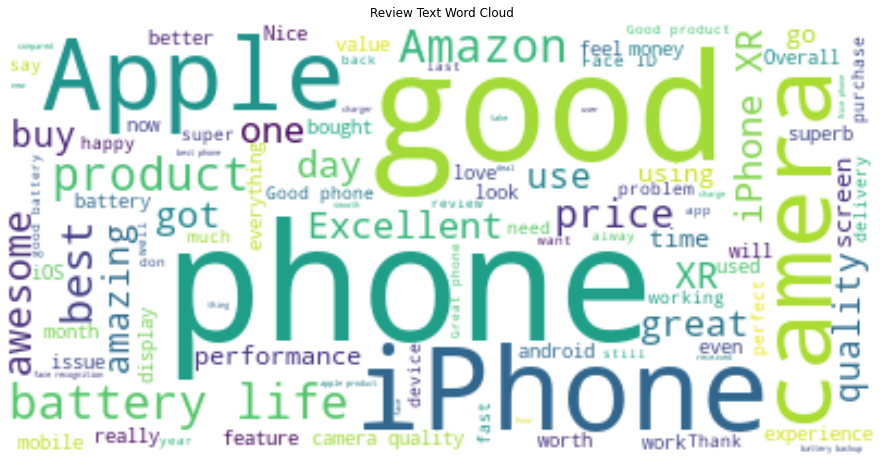

In [17]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
#     stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud')
plt.axis("off")
plt.show()

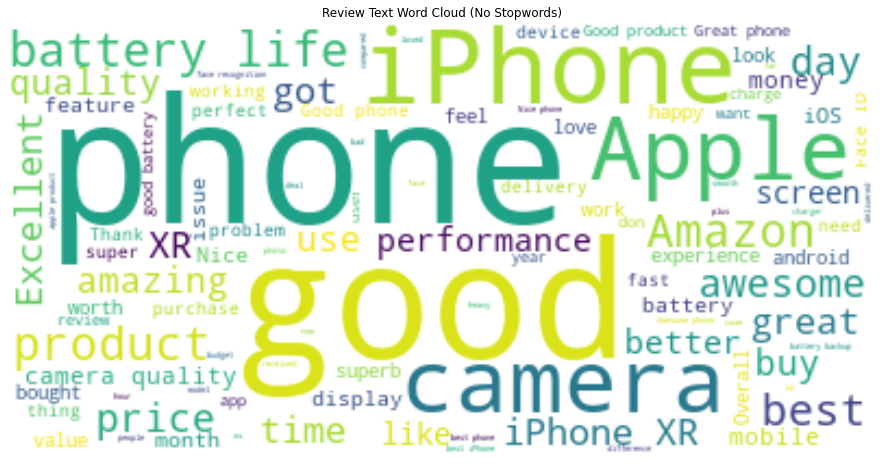

In [18]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

100%|██████████| 3870/3870 [00:00<00:00, 61729.73it/s]


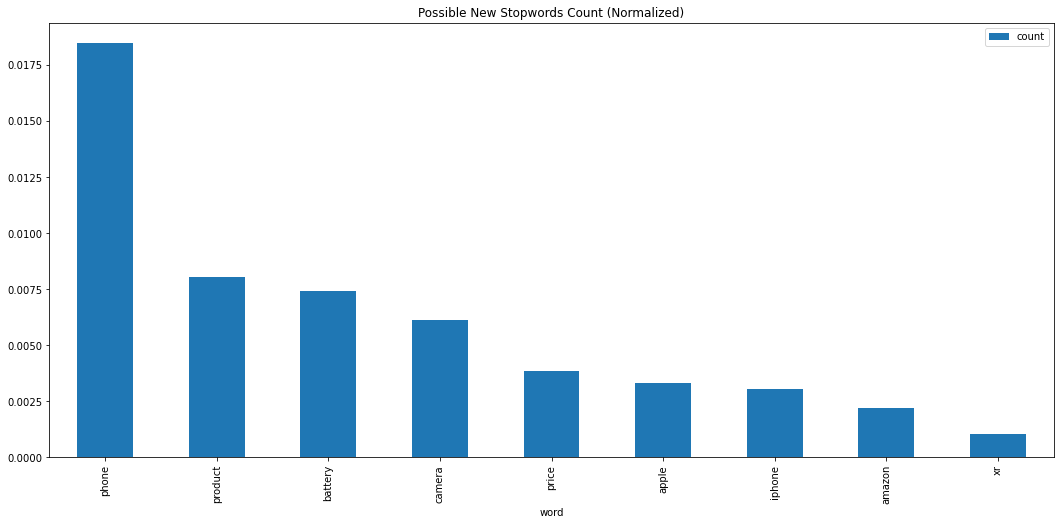

In [19]:
new_stopwords = ['amazon', 'phone', 'xr', 'iphone', 'apple', 'product', 'camera', 'price', 'battery']
word_count = Counter()

for text in tqdm(df['text']):
    text = ''.join([i for i in text if i not in punc])
    for word in text.split():
        if word in new_stopwords:
            word_count[word] += 1
            
(pd.DataFrame(word_count.most_common(), columns='word count'.split())\
    .set_index('word') / df['text'].apply(lambda x: len(x.split())).sum())\
    .plot.bar(title='Possible New Stopwords Count (Normalized)')
plt.show()

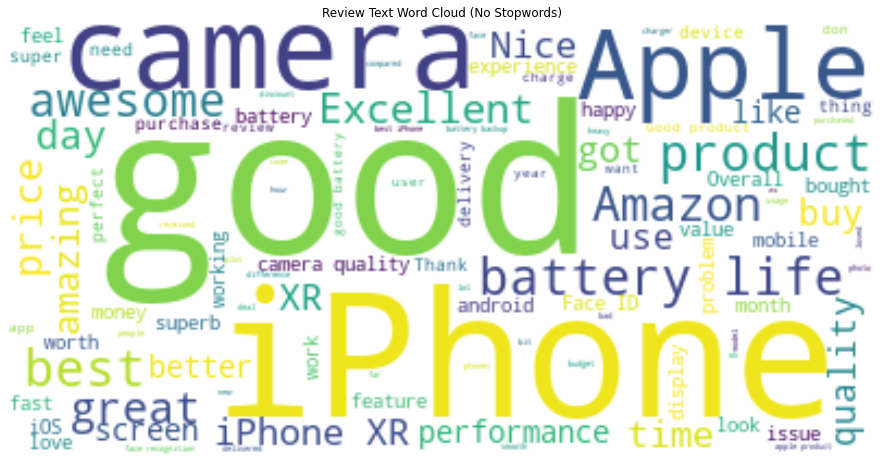

In [20]:
stop.add('phone')

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

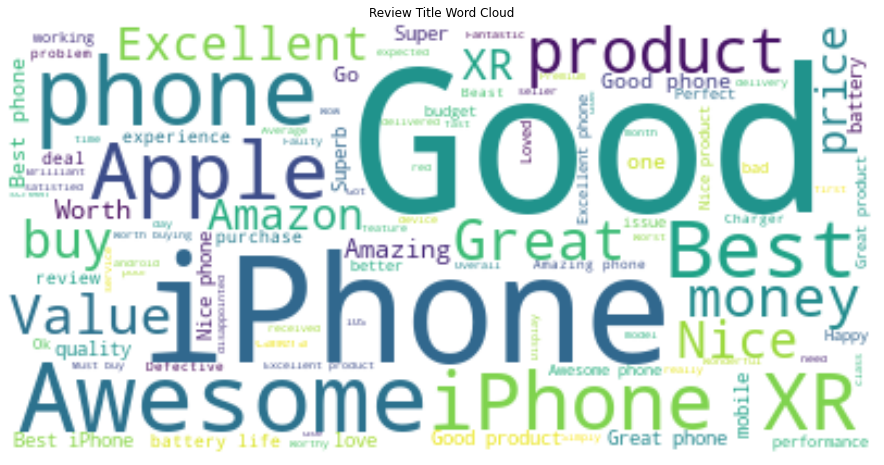

In [21]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
#     stopwords=stop
).generate('\n'.join(list(df['title'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Title Word Cloud')
plt.axis("off")
plt.show()

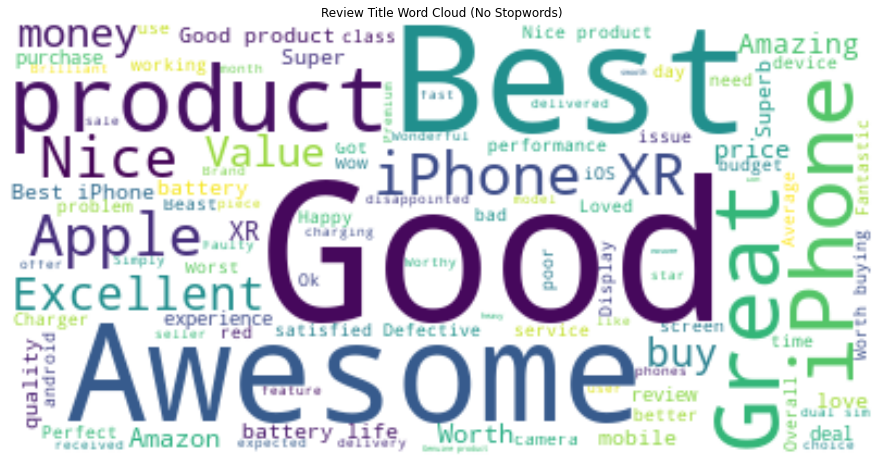

In [22]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['title'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Title Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

In [23]:
punc = set(string.punctuation)

text_word_counter = Counter()
title_word_counter = Counter()
text_adj_counter = Counter()
text_adv_counter = Counter()
text_word_unique_appearence_frequency = Counter()
title_word_unique_appearence_frequency = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text', 'title']]
    text = ''.join([i for i in text.lower() if i not in punc])
    title = ''.join([i for i in title.lower() if i not in punc])
    ttitle_words, ttext_words = set(), set()
    for token in nlp(text):
        if token.is_space:
            break
        word = token.text
        pos = token.pos_
        if pos == 'ADV':
            text_adv_counter[word] += 1
        elif pos == 'ADJ':
            text_adj_counter[word] += 1
        for ttext in df['text']:
            if word in ttext_words:
                break
            elif word in ttext.lower():
                text_word_unique_appearence_frequency[word] += 1
                ttext_words.add(word)
                break
        if word not in stop:
            text_word_counter[word] += 1
    for token in nlp(title):
        if token.is_space:
            break
        word = token.text
        for ttile in df['title']:
            if word in ttitle_words:
                break
            elif word in ttile.lower():
                title_word_unique_appearence_frequency[word] += 1
                ttitle_words.add(word)
                break
        if word not in stop:
            title_word_counter[word] += 1

100%|██████████| 3870/3870 [01:49<00:00, 35.45it/s]


In [24]:
def visualize_counter(counter, title, xlabel='Word', ylabel='Frequency', n=50, descending=True):
    '''
    Visualize word frequency count from a Counter object
    '''
    z = counter.most_common()
    if descending:
        x = [i[0] for i in z][:n]
        y = [i[1] for i in z][:n]
    else:
        x = [i[0] for i in z][-n:]
        y = [i[1] for i in z][-n:]

    fig = go.Figure(
        data=[go.Bar(x=x, y=y)],
        layout=dict(
            title=dict(text=title, x=0.5),
            xaxis=dict(title_text=xlabel),
            yaxis=dict(title_text=ylabel),
        ),
    )

    fig.show()

In [25]:
visualize_counter(text_adv_counter, 'Text Adverbs Frequency')

In [26]:
visualize_counter(text_adj_counter, 'Text Adjectives Frequency')

In [27]:
visualize_counter(text_word_counter, 'Text Word Frequency')

In [28]:
visualize_counter(title_word_counter, 'Title Word Frequency')

In [29]:
visualize_counter(text_word_unique_appearence_frequency, 'Word Appearence in Review\'s Text')

In [30]:
visualize_counter(title_word_unique_appearence_frequency, 'Word Appearence in Review\'s Title')

## Data Cleaning

In [31]:
def clean(doc):
    # lower text and remove punctuations
    s = ''
    for char in doc.lower():
        s += char if char not in punc else ' '
    # remove stopwords, adjectives, and adverbs
    normalized = []
    for token in nlp(s):
        if not (token.is_space or token.is_stop or token.pos_ == 'ADJ' or token.pos_ == 'ADV'):
            # stem and lemmatize text
            t = stemmer.stem(token.lemma_)
            normalized.append(t)
    normalized = " ".join(normalized)
    return normalized

In [32]:
df['text'][31]

'This Appario seem to be a fraud. My shipment has been smartly tampered and the have managed to overcome the security features. Even iPhone package back label have been tampered. Amazon Customer Care on phone or Twitter is of no help. I need to return this and get a replacement.'

In [33]:
clean(df['text'][31])

'appario fraud shipment tamper manag overcom secur featur packag label tamper amazon custom care twitter help need return replac'

In [34]:
text_clean = [clean(doc) for doc in tqdm(df['text'])]
title_clean = [clean(doc) for doc in tqdm(df['title'])]

df['title_clean'] = title_clean
df['text_clean'] = text_clean

df.head()

100%|██████████| 3870/3870 [00:32<00:00, 120.49it/s]


,title,date,location,rating,text,title_clean,text_clean
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...,iphon purchas iphon 8 x xs xr,note comparison iphon 8 x xs xr month state ba...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....,don t buy iphon xr amazon,experi iphon xr camera find amazon haven t get...
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...,purchas,camera come iphon 7 plus servic amazon
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...,amazon appl resel note,get iphon xr today product look face d work gl...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...,excel batteri life butteri ui,ve android user life decid tri iphon xr io lov...


In [35]:
df[(df['text_clean'].apply(lambda x: x.strip()) == '')].shape

(593, 7)

In [36]:
df = df[(df['text_clean'].apply(lambda x: x.strip()) != '')]

## Save cleaned data

In [37]:
path = '../cleaned_data'
if not os.path.exists(path):
    os.makedirs(path)
    
df.to_parquet(os.path.join(path, 'cleaned_reviews.parquet.gzip'), index=False)

## Post-Cleaning Data Exploration

In [38]:
# stop = set(stopwords.words('english'))

text_word_counter = Counter()
title_word_counter = Counter()
text_word_unique_appearence_frequency = Counter()
title_word_unique_appearence_frequency = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text_clean', 'title_clean']]
    text = text.lower()
    title = title.lower()
    ttitle_words, ttext_words = set(), set()
    for word in text.split():
        for ttext in df['text']:
            if word in ttext_words:
                continue
            elif word in ttext.lower():
                text_word_unique_appearence_frequency[word] += 1
                ttext_words.add(word)
        if word not in stop:
            text_word_counter[word] += 1
    for word in title.split():
        for ttile in df['title']:
            if word in ttitle_words:
                continue
            elif word in ttile.lower():
                title_word_unique_appearence_frequency[word] += 1
                ttitle_words.add(word)
        if word not in stop:
            title_word_counter[word] += 1
else:
    total_words_in_text = sum(text_word_counter.values())
    total_words_in_title = sum(title_word_counter.values())
    for k, v in text_word_counter.items():
        text_word_counter[k] = v / total_words_in_text
    for k, v in text_word_unique_appearence_frequency.items():
        text_word_unique_appearence_frequency[k] = v / df.shape[0]
    for k, v in title_word_counter.items():
        title_word_counter[k] = v / total_words_in_title
    for k, v in title_word_unique_appearence_frequency.items():
        title_word_unique_appearence_frequency[k] = v / df.shape[0]

100%|██████████| 3277/3277 [00:31<00:00, 103.68it/s]


In [39]:
visualize_counter(text_word_counter, 'Text Word Frequency (Normalized)')

In [40]:
visualize_counter(title_word_counter, 'Text Word Frequency (Normalized)')

In [41]:
visualize_counter(text_word_unique_appearence_frequency, 'Word Appearence in Review\'s Text (Normalized)')

In [42]:
visualize_counter(title_word_unique_appearence_frequency, 'Word Appearence in Review\'s Title (Normalized)')

## Adding The Data Cleaning Process To Production Pipeline

In [43]:
!pygmentize helper_scripts/data_cleaning.py

import pandas as pd
import os
from tqdm import tqdm
from clean_func import clean

df = pd.read_parquet("../scraped_data/reviews.parquet.gzip")

text_clean = [clean(doc) for doc in tqdm(df["text"])]
title_clean = [clean(doc) for doc in tqdm(df["title"])]

df["title_clean"] = title_clean
df["text_clean"] = text_clean

df = df[(df["text_clean"].apply(lambda x: x.strip()) != "")]

path = "../cleaned_data"
if not os.path.exists(path):
    os.makedirs(path)

df.to_parquet(os.path.join(path, "cleaned_reviews.parquet.gzip"), index=False)


In [44]:
!pygmentize helper_scripts/clean_func.py

from nltk.stem import SnowballStemmer

# import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS as stop
import os
import string
import nltk

try:
    stemmer = SnowballStemmer("english")
except:
    nltk.download("wordnet")
    stemmer = SnowballStemmer("english")

try:
    nlp = en_core_web_sm.load()
except:
    os.system("python -m spacy download en_core_web_sm")
    nlp = en_core_web_sm.load()

stop.add("phone")

punc = set(string.punctuation)


def clean(doc):
    # lower text and remove punctuations
    s = ""
    for char in doc.lower():
        s += char if char not in punc else " "
    # remove stopwords, adjectives, and adverbs
    normalized = []
    for token in nlp(s):
        if not (
            token.is_space
            or token.is_stop
            or token.pos_ == "ADJ"
            or token.pos_ == "ADV"
        ):
            # stem and lemmatize text
            t = stemmer.stem(token.lemma_)
            normalized.append(t)
    normalized

## Closing Remarks